# Bayesian optimization with Gaussian processes

Gaussian process is a [random process](https://en.wikipedia.org/wiki/Stochastic_process) used to approximate a function $y = f(\mathbf{x})$ with a *distribution over functions* $\mathbf{f} \sim \mathcal{GP}$. What does it say, is that it tells us what is a probability of observing a particular realization $f(\mathbf{x})$ of a function $f \in \mathbf{f}$ for the input $\mathbf{x}$. As described by Rasmussen and Williams (2006),

> A Gaussian *process* is a generalization of the Gaussian probability *distribution*. Whereas a probability distribution describes random variables which are scalars or vectors (for multivariate distributions), a stochastic *process* governs the properties of functions. Leaving mathematical sophistication aside, one can loosely think of a function as a very long vector, each entry in the vector specifying the function value $f(x)$ at a particular input $x$. It turns out, that although this idea is a little naı̈ve, it is surprisingly close
what we need.

It starts with assuming a *prior* over the possible functions, so that we can combine it with data, apply [Bayes theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem), and obtain a *posterior*, to estimate  the distribution over functions given the data. The distribution is assumed to be [multivariate Gaussian](https://en.wikipedia.org/wiki/Multivariate_normal_distribution)

$$
\left[ {\begin{array}{c}
f(x_1) \\
f(x_2) \\
\vdots \\
f(x_N) \\
\end{array}} \right] \sim \mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\Sigma})
$$

Because of choosing Gaussian prior and likelihood, by [conjugacy](https://en.wikipedia.org/wiki/Conjugate_prior), we have a closed-form solution for the posterior, that is a Gaussian as well. Moreover, the marginal distributions are also Gaussians. Having Gaussians everywhere is not a coincidence, but a design decission that makes our life easier. In Gaussian process, the mean $\boldsymbol{\mu}$ is defined by a mean function $m(\mathbf{x}) = \mathbb{E}[f(\mathbf{x})]$, and covariance matrix $\boldsymbol{\Sigma}$, with a covariance function $k(\mathbf{x}, \mathbf{x}') = \mathbb{E}[(f(\mathbf{x}) - m(\mathbf{x}))(f(\mathbf{x}') - m(\mathbf{x}'))]$, we can write this as

$$
f(\mathbf{x}) \sim \mathcal{GP}\left(m(\mathbf{x}),\, k(\mathbf{x}, \mathbf{x}')\right)
$$

To make predictions from Gaussian process, we need to learn the covariance matrix (mean is often assumed to be zero, to simplify the computations). As said above, covariance function is defined in terms of [kernels](https://stats.stackexchange.com/questions/2499/what-is-a-kernel-in-plain-english) $k(\mathbf{x}_i, \mathbf{x}_j)$, that are [generalizations of dot products](https://stats.stackexchange.com/questions/152897/how-to-intuitively-explain-what-a-kernel-is), and can intuitively be thought as [measuring similarity](https://math.stackexchange.com/questions/689022/how-does-the-dot-product-determine-similarity) between $\mathbf{x}_i$ and $\mathbf{x}_j$ points (think of [cosine similarity](https://datascience.stackexchange.com/questions/744/cosine-similarity-versus-dot-product-as-distance-metrics)), so [points in feature space that are closer together, produce outputs that are closer together](https://katbailey.github.io/post/gaussian-processes-for-dummies/). The simplest possible kernel is *linear kernel*, that *is* the dot product, $k(\mathbf{x}_i,\mathbf{x}_j) = \mathbf{x}_i^\top \mathbf{x}_j$. Another example, and one of the most popular kernels, is the *squared exponential*, also known as *radial basis function* (RBF), or *Gaussian* kernel

$$
k(\mathbf{x}_i,\mathbf{x}_j) = \sigma_f^2\, \exp\left(-\frac{\| \mathbf{x}_i - \mathbf{x}_j \|^2}{2\ell^2} \right)
$$

It has two parameters $\ell$ for *characteristic length-scale* (smoothness) and $\sigma$ for the vertical variation (magnitude) of the outputs (see [those plots](#Prior-samples-with-different-RBF-kernel-hyperparameters) for some examples).

To find the covariance matrix, we will be evaluating kernel over all the pairs of points $\boldsymbol{\Sigma}_{ij} = k(\mathbf{x}_i, \mathbf{x}_j)$, for the training set $X$, and test set $X_*$ (the new points, we want to make predictions for). The matrix can be partitioned to submatrices of "similarities" between the training points $K = K(X, X)$, training and test points $K_* = K(X, X_*)$, and between the test points $K_{**} = K(X_*, X_*)$. Assuming noise-free observations, the resulting joint distribution is

$$
\left[ {\begin{array}{c}
\mathbf{f}\phantom{_*} \\
\mathbf{f}_* \\
\end{array}} \right] 
\sim
\mathcal{N} \left(
\left[ {\begin{array}{c}
\boldsymbol{\mu}\phantom{_*} \\
\boldsymbol{\mu}_* \\
\end{array}} \right], \;
\left[ {\begin{array}{cc}
K\phantom{_*^\top} & K_*\phantom{_*} \\
K_*^\top & K_{**} \\
\end{array}} \right] 
\right)
$$

We [can calculate](https://krasserm.github.io/2018/03/19/gaussian-processes/) the predictive mean and covariance for the test set by

$$
\begin{align}
\boldsymbol{\mu_*} &= K_*^\top K^{-1} y \\
\boldsymbol{\Sigma_*} &= K_{**} - K_*^\top K^{-1} K_*
\end{align}
$$

If we are given noisy realisations of the function $y = f(\mathbf{x}) + \varepsilon$, with Gaussian noise $\varepsilon \sim \mathcal{N}(0, \sigma^2_n)$, then we can correct the covariance between training data accounting for noise

$$
K = K(X, X) + \sigma^2_n I
$$

In [1]:
using Plots
using LinearAlgebra
using Distributions
import Random

Random.seed!(42)

Random.MersenneTwister(UInt32[0x0000002a], Random.DSFMT.DSFMT_state(Int32[964434469, 1073036706, 1860149520, 1073503458, 1687169063, 1073083486, -399267803, 1072983952, -909620556, 1072836235  …  -293054293, 1073002412, -1300127419, 1073642642, 1917177374, -666058738, -337596527, 1830741494, 382, 0]), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], UInt128[0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000  …  0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x000

In [2]:
function rbf(x, y; σ = 1, l = 1)
    d = x .- y
    return σ * exp(-(d'd) / (2 * l^2))
end

function apply_kernel(kernel, X, Y)
    n, m = size(X, 1), size(Y, 1)
    return [ kernel(X[i, :], Y[j, :]) for i = 1:n, j = 1:m ]
end

struct GaussianProcess
    X # design points
    y # objective points
    k # kernel
    σ # noise variance
    
    GaussianProcess(X, y; k = rbf, σ = eps()) = new(X, y, k, σ)
end

function kernel(GP, X_new)
    K_xx = apply_kernel(GP.k, GP.X, GP.X)
    K_xs = apply_kernel(GP.k, GP.X, X_new)
    K_ss = apply_kernel(GP.k, X_new, X_new)
    return K_xx, K_xs, K_ss
end

function random_mvn(μ, Σ, n = 1)
    # correction to prevent numerical issues
    Σ = Symmetric(Σ + I * 1e-6)
    return rand(MvNormal(μ, Σ), n)
end

random_mvn (generic function with 2 methods)

### Data

In [3]:
X = [-4, -3.8, -2, -1, 1]
y = sin.(X)
X_new = [range(-5, 5, step = 0.1);]

size(X), size(y), size(X_new)

((5,), (5,), (101,))

### Prior

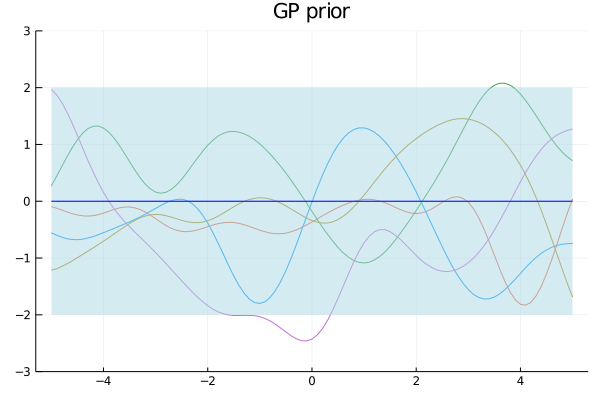

In [4]:
K_ss = apply_kernel(rbf, X_new, X_new)
μ_s = zeros(size(K_ss, 1))
σ_s = diag(K_ss)

plot(X_new, random_mvn(μ_s, K_ss, 5), legend = false, title = "GP prior", ylim = (-3, 3))
plot!(X_new, μ_s, ribbon=(2σ_s, 2σ_s), c = :lightblue, label = false)
plot!(X_new, zeros(length(X_new)), c = :blue)

### Prior samples with different RBF kernel hyperparameters

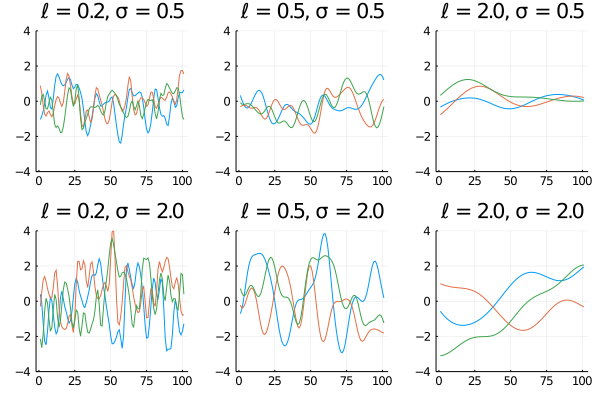

In [5]:
grid_vals = 0:0.1:10
μ_s = zeros(size(grid_vals, 1))

plots = []
for (l, σ) in Iterators.product([0.2, 0.5, 2], [0.5, 2])
    K_ss = apply_kernel((x, y) -> rbf(x, y, l = l, σ = σ), grid_vals, grid_vals)
    push!(plots, plot(random_mvn(μ_s, K_ss, 3), label = false, title = "ℓ = $l, σ = $σ", ylim = (-4, 4)))
end
plot(plots...)

### Posterior

In [6]:
σ_n = 0.1
gp = GaussianProcess(X, y, σ = σ_n)
K_xx, K_xs, K_ss = kernel(gp, X_new)

size(K_xx), size(K_xs), size(K_ss)

((5, 5), (5, 101), (101, 101))

In [7]:
function posterior_direct(y, K_xx, K_xs, K_ss, σ)
    K_inv = inv(K_xx + σ * I)
    μ_s = K_xs' * K_inv * y
    Σ_s = K_ss - K_xs' * K_inv * K_xs
    return μ_s, Σ_s
end

posterior_direct (generic function with 1 method)

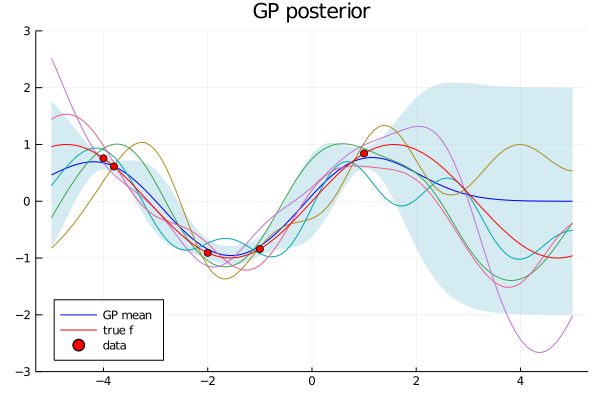

In [8]:
μ_s, Σ_s = posterior_direct(y, K_xx, K_xs, K_ss, σ_n)
σ_s = diag(Σ_s)

plot(X_new, μ_s, ribbon = (2σ_s, 2σ_s), c = :lightblue, label = false)
plot!(X_new, μ_s, label = "GP mean", c = :blue)
plot!(X_new, random_mvn(μ_s, Σ_s, 5), label = false)
plot!(sin, label = "true f", c = :red)
scatter!(X, y, label = "data", title = "GP posterior", ylim = (-3, 3), legend = :bottomleft, c = :red)

Posterior can be calculated directly, but as noticed by Rasmussen and Williams (2006), there is more efficient algorithm for this, that is both faster and more stable. [We will see later](#Benchmark), that indeed, the larger the data, the more efficient it gets to use the algorithm.

In [9]:
function posterior(y, K_xx, K_xs, K_ss, σ)
    L = cholesky(K_xx + σ * I).L
    α = L' \ (L \ y)
    μ_s = K_xs' * α
    v = L \ K_xs
    Σ_s = K_ss - v'v
    return μ_s, Σ_s
end

posterior (generic function with 1 method)

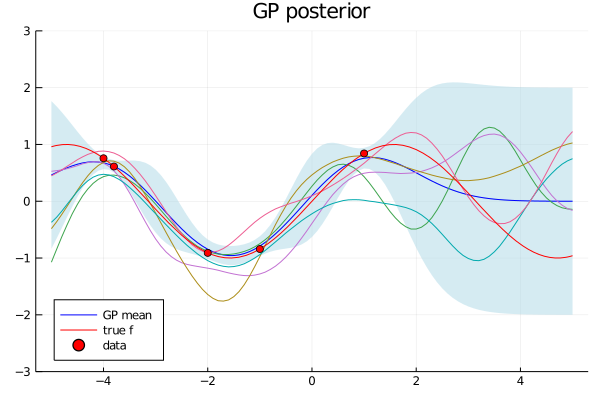

In [10]:
μ_s, Σ_s = posterior(y, K_xx, K_xs, K_ss, σ_n)
σ_s = diag(Σ_s)

plot(X_new, μ_s, ribbon = (2σ_s, 2σ_s), c = :lightblue, label = false)
plot!(X_new, μ_s, label = "GP mean", c = :blue)
plot!(X_new, random_mvn(μ_s, Σ_s, 5), label = false)
plot!(sin, label = "true f", c = :red)
scatter!(X, y, label = "data", title = "GP posterior", ylim = (-3, 3), legend = :bottomleft, c = :red)

## Benchmark

In [11]:
using BenchmarkTools

σ_n = 1

for n in [5, 100, 500]
    println("Number of samples N=$n")
    
    X = [range(-5, 5, length = n);]
    y = sin.(X)
    
    gp = GaussianProcess(X, y, σ = σ_n)
    K_xx, K_xs, K_ss = kernel(gp, X)
    
    @btime posterior_direct(y, K_xx, K_xs, K_ss, σ_n)
    @btime posterior(y, K_xx, K_xs, K_ss, σ_n)
    
    println()
end

Number of samples N=5
  2.380 μs (11 allocations: 4.63 KiB)
  3.341 μs (12 allocations: 2.14 KiB)

Number of samples N=100
  380.688 μs (17 allocations: 521.16 KiB)
  184.238 μs (18 allocations: 471.92 KiB)

Number of samples N=500
  42.137 ms (17 allocations: 11.70 MiB)
  5.853 ms (18 allocations: 11.46 MiB)



## Using Gaussian Process for optimization

We can use Gaussian process for optimizing expensive (computationally demanding, or slow to compute) functions by using it to *approximate* those functions and optimize the approximates instead. In such case, we fit Gaussian process to outputs of the expensive target function, and then use it to pick next candidate point to evaluate. The use cases for such optimization can be, for example, reinforcement learning, or hyperparameter tuning.

Optimizing something like mean of the Gaussian process directly would be pure exploitation, but in optimization there is an [exploration-exploitation trade-off](https://towardsdatascience.com/intuition-exploration-vs-exploitation-c645a1d37c7a), and we would probably like to explore the space of unseen outcomes more. To solve it, we can optimize an *acquisition functions* instead, the common examples are:

 - *Upper confidence bound* (for maximization), or *lower confidence bound* (for minimization), i.e. correcting the expectation for predictions $\mu$ for uncertainity related to them, so that we also want to explore the areas that are uncertain to us.
 - *Thompson sampling* uses different approach, it uses a randomized strategy, where instead of picking single "most promissing" acquisition function to optimize, we draw a random sample of the possible outcomes and optimize them.
 - *Probability of improvement* tells us what candidate has highest probability for generating the more optimal outcome.
 - *Expected improvement* is similar to the probability of improvement, but corrects for the size of the potential improvement, so that we are more likely to pick larger improvements first.
 
More details can be found in the paper by [Brochu et al (2010)](https://arxiv.org/abs/1012.2599), or the [*Algorithms for Optimization*](https://mitpress.mit.edu/books/algorithms-optimization) book by Kochenderfer and Wheeler (2019).

In [12]:
function posterior(GP, X_new)
    K_xx, K_xs, K_ss = kernel(GP, X_new)
    return posterior(GP.y, K_xx, K_xs, K_ss, GP.σ)
end

posterior (generic function with 2 methods)

In [13]:
phi(x) = pdf(Normal(), x)
Phi(x) = cdf(Normal(), x)

function confidence_bound(μ, σ; c = 3, minimize = true)
    return μ + (minimize ? -c : c) * σ
end

function probability_of_improvement(μ, σ, y_opt; ξ = 0, minimize = true)
    if minimize
        d = (y_opt - ξ) - μ
    else
        d = μ - (y_opt + ξ)
    end
    return Phi(d / σ)
end

function expected_improvement(μ, σ, y_opt; ξ = 0, minimize = true)
    if minimize
        d = (y_opt - ξ) - μ
    else
        d = μ - (y_opt + ξ)
    end
    return d * Phi(d / σ) + σ * phi(d / σ)
end

expected_improvement (generic function with 1 method)

## Simple example of Bayesian optimization

In [14]:
scale(x) = ((x .- minimum(x)) ./ (maximum(x) - minimum(x)))

function simulate(; method = "UCB", iters = 15, c = 3, σ_n = 0.1, ξ = 0.01)
    
    f_true(x) = sin(x) - 0.1 * x^2
    f_noisy(x) = f_true(x) + randn() * σ_n
    
    grid = -5:0.1:6
    
    idx = rand(1:length(grid))
    X = [grid[idx]]
    y = f_noisy.(X)
    y_max = y

    anim = @animate for i in 1:iters
        
        gp = GaussianProcess(X, y, σ = σ_n)
        μ, Σ = posterior(gp, [grid;])
        σ = diag(Σ)

        if method == "UCB"
            crit = confidence_bound.(μ, σ, c=c, minimize = false)
        elseif method == "PI"
            crit = probability_of_improvement.(μ, σ, y_max, ξ=ξ, minimize = false)
        elseif method == "EI"
            crit = expected_improvement.(μ, σ, y_max, ξ=ξ, minimize = false)
        else
            crit = random_mvn(μ, Σ)
        end
        idx = argmax(crit)

        X_new = grid[idx]
        y_new = f_noisy.(X_new)
        y_max = max.(y_max, y_new)

        plot(title = "GP $method - Iteration $(i - 1) / $iters", ylim = (-4.5, 4), legend = :topleft)

        plot!(grid, μ, ribbon = (2σ, 2σ), c = :lightblue)
        plot!(grid, μ, label = "GP mean", c = :blue)

        plot!(f_true, -5, 6, label = "true f", c = :red)
        scatter!(X, y, label = "data", c = :red)

        crit = scale(crit) .* 1.5 .- 4.2
        plot!(grid, crit, label = "acquisition function", c = :green, ls = :dash)
        scatter!([X_new], [μ[idx]], c = :blue, label = "proposed point")
        scatter!([X_new], [crit[idx]], markersize = 25, markershape = :vline, c = :green, label = false)

        push!(X, X_new)
        push!(y, y_new)
    end
    
    return anim
end

simulate (generic function with 1 method)

┌ Info: Saved animation to 
│   fn = /home/tymek/Documents/Private/LearningJulia/tmp.gif
└ @ Plots /home/tymek/.julia/packages/Plots/M1wcx/src/animation.jl:104


Plots.AnimatedGif("/home/tymek/Documents/Private/LearningJulia/tmp.gif")
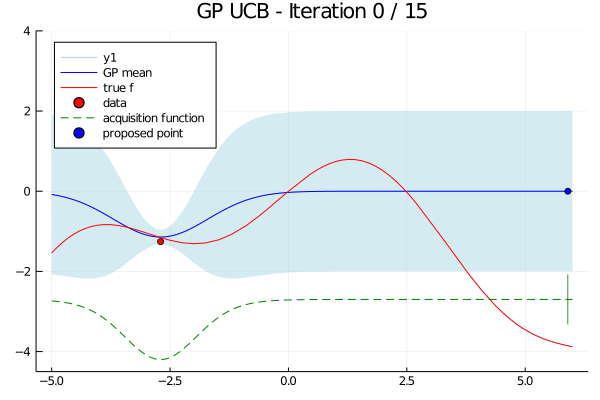

In [15]:
anim = simulate(method = "UCB")
gif(anim, fps = 1)

┌ Info: Saved animation to 
│   fn = /home/tymek/Documents/Private/LearningJulia/tmp.gif
└ @ Plots /home/tymek/.julia/packages/Plots/M1wcx/src/animation.jl:104


Plots.AnimatedGif("/home/tymek/Documents/Private/LearningJulia/tmp.gif")
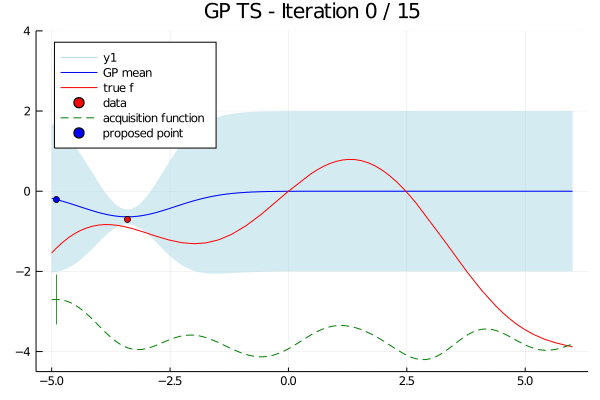

In [16]:
anim = simulate(method = "TS")
gif(anim, fps = 1)

┌ Info: Saved animation to 
│   fn = /home/tymek/Documents/Private/LearningJulia/tmp.gif
└ @ Plots /home/tymek/.julia/packages/Plots/M1wcx/src/animation.jl:104


Plots.AnimatedGif("/home/tymek/Documents/Private/LearningJulia/tmp.gif")
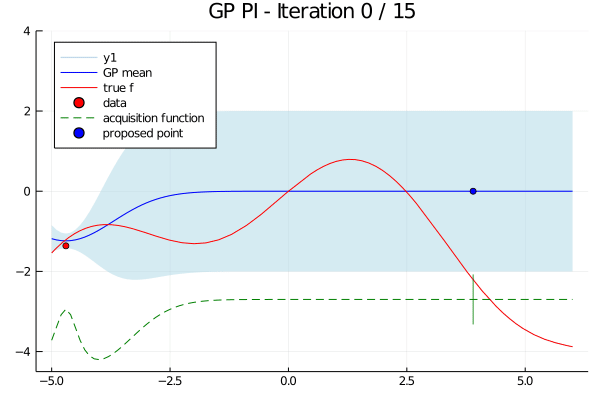

In [17]:
anim = simulate(method = "PI")
gif(anim, fps = 1)

┌ Info: Saved animation to 
│   fn = /home/tymek/Documents/Private/LearningJulia/tmp.gif
└ @ Plots /home/tymek/.julia/packages/Plots/M1wcx/src/animation.jl:104


Plots.AnimatedGif("/home/tymek/Documents/Private/LearningJulia/tmp.gif")
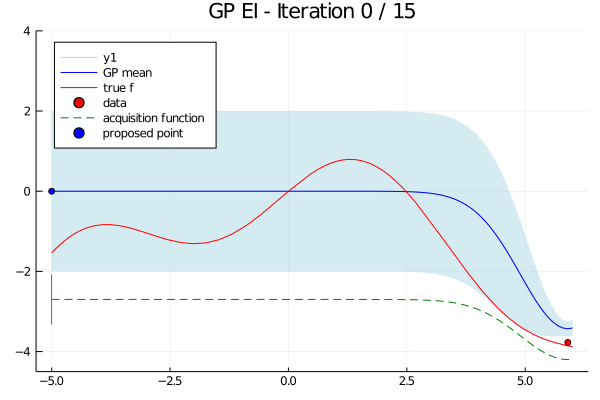

In [18]:
anim = simulate(method = "EI")
gif(anim, fps = 1)

## Example of Bayesian optimization in multi-dimensional space

In [19]:
function makegrid(x, y) 
    n, m = length(x), length(y)
    vec = Array{Any}(undef, (n * m, 2))
    row = 1
    for xi in x
        for yi in y
            vec[row, :] = [xi, yi]
            row += 1
        end
    end
    return vec
end

function vector2matrix(vec::AbstractArray{T, 1}, n, m) where T <: Any
    @assert length(vec) == n * m
    out = Array{T}(undef, n, m)
    row = 1
    for i in 1:n
        for j in 1:m
            out[i, j] = vec[row]
            row += 1
        end
    end
    return out
end

vector2matrix (generic function with 1 method)

In [20]:
wheeler(x; a = 1.5) = -exp(-(x[1] * x[2] - a)^2 - (x[2] - a)^2)

function simulate2d(; method = "UCB", iters = 50, c = 3, σ_n = 0.1, ξ = 0.01)
    
    X = reshape(rand(2), (1, 2))
    y = [wheeler(X)]
    y_min = y
    
    # this is used only for plotting, so that points do not overlap
    jitter = randn((iters, 2)) * 0.025
    
    l, u = -1, 4
    grid_size = 52
    grid_vals = range(l, u, length = grid_size)
    grid = makegrid(grid_vals, grid_vals)

    anim = @animate for i in 1:iters
                
        gp = GaussianProcess(X, y, σ = σ_n)
        
        μ, Σ = posterior(gp, grid)
        σ = diag(Σ)
        
        if method == "UCB"
            crit = -confidence_bound.(μ, σ, c = c)
        elseif method == "PI"
            crit = probability_of_improvement.(μ, σ, y_min, ξ = ξ)
        elseif method == "EI"
            crit = expected_improvement.(μ, σ, y_min, ξ = ξ)
        else
            crit = -random_mvn(μ, Σ)[:]
        end
        
        idx = argmax(crit)        
        X_new = reshape(grid[idx, :], (1, 2))
        y_new = [wheeler(X_new)]
        y_min = min.(y_min, y_new)

        p1 = plot(xlim = (l, u), ylim = (l, u), legend = false, title = "Acquisition function")
        heatmap!(grid_vals, grid_vals, scale(vector2matrix(crit, length(grid_vals), length(grid_vals))), clims = (0, 1), colorbar = false)
        
        p2 = plot(xlim = (l, u), ylim = (l, u), legend = false, title = "Iteration $(i - 1) / $iters")
        contour!(grid_vals, grid_vals, (x, y) -> wheeler([x y]), colorbar = false)
        scatter!(X[:, 1] .+ jitter[1:i, 1], X[:, 2] .+ jitter[1:i, 2], c = :red)
        
        plot(p1, p2)

        X = [X; X_new]
        y = [y; y_new]
    end
    return anim
end

simulate2d (generic function with 1 method)

┌ Info: Saved animation to 
│   fn = /home/tymek/Documents/Private/LearningJulia/tmp.gif
└ @ Plots /home/tymek/.julia/packages/Plots/M1wcx/src/animation.jl:104


Plots.AnimatedGif("/home/tymek/Documents/Private/LearningJulia/tmp.gif")
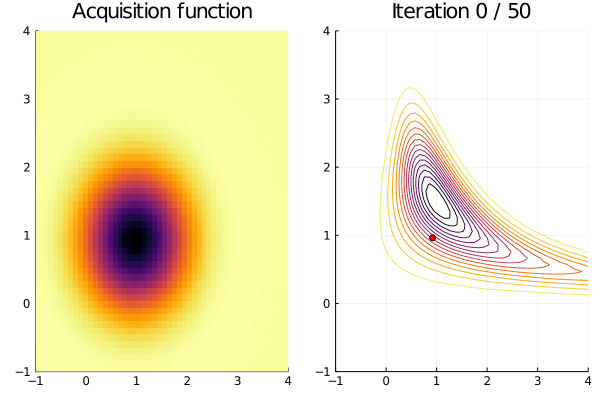

In [21]:
anim = simulate2d(method = "UCB")
gif(anim, fps = 5)

┌ Info: Saved animation to 
│   fn = /home/tymek/Documents/Private/LearningJulia/tmp.gif
└ @ Plots /home/tymek/.julia/packages/Plots/M1wcx/src/animation.jl:104


Plots.AnimatedGif("/home/tymek/Documents/Private/LearningJulia/tmp.gif")
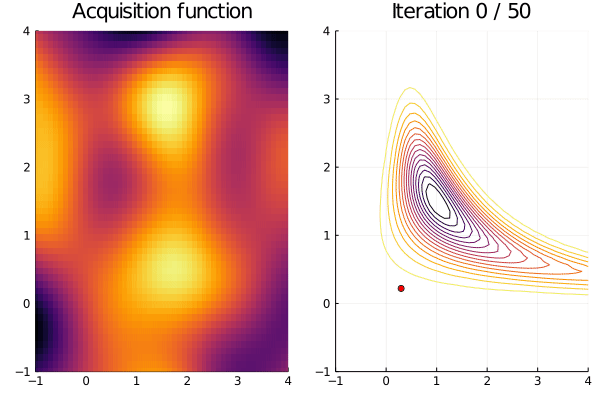

In [22]:
anim = simulate2d(method = "TS")
gif(anim, fps = 5)

┌ Info: Saved animation to 
│   fn = /home/tymek/Documents/Private/LearningJulia/tmp.gif
└ @ Plots /home/tymek/.julia/packages/Plots/M1wcx/src/animation.jl:104


Plots.AnimatedGif("/home/tymek/Documents/Private/LearningJulia/tmp.gif")
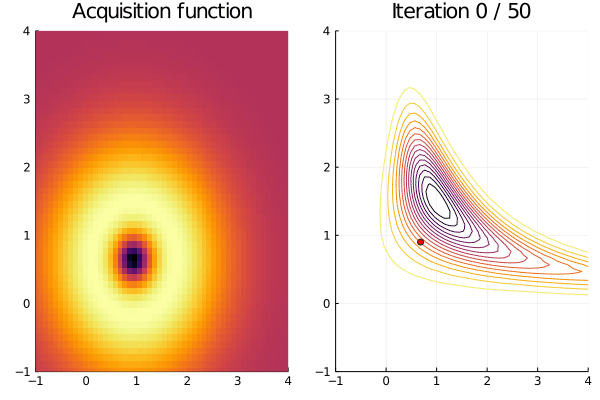

In [23]:
anim = simulate2d(method = "PI")
gif(anim, fps = 5)

┌ Info: Saved animation to 
│   fn = /home/tymek/Documents/Private/LearningJulia/tmp.gif
└ @ Plots /home/tymek/.julia/packages/Plots/M1wcx/src/animation.jl:104


Plots.AnimatedGif("/home/tymek/Documents/Private/LearningJulia/tmp.gif")
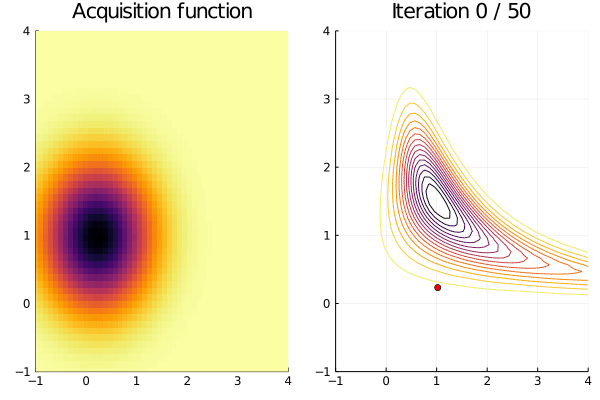

In [24]:
anim = simulate2d(method = "EI")
gif(anim, fps = 5)

## Further reading

### Blog posts
Katherine Bailey (Aug 9, 2016) [Gaussian Processes for Dummies](https://katbailey.github.io/post/gaussian-processes-for-dummies/)  
Martin Krasser (Mar 19, 2018) [Gaussian processes](https://krasserm.github.io/2018/03/19/gaussian-processes/)  
Martin Krasser (Mar 21, 2018) [Bayesian optimization](https://krasserm.github.io/2018/03/21/bayesian-optimization/)  
Jochen Görtler, Rebecca Kehlbeck, Oliver Deussen (Apr 2, 2019) [A Visual Exploration of Gaussian Processes](https://distill.pub/2019/visual-exploration-gaussian-processes/)  
Apoorv Agnihotri, Nipun Batra (May 5, 2020) [Exploring Bayesian Optimization](https://distill.pub/2020/bayesian-optimization/)  
Chris Fonnesbeck (Mar 8, 2017) [Fitting Gaussian Process Models in Python](https://blog.dominodatalab.com/fitting-gaussian-process-models-python/)  
Charles Brecque (Sep 26, 2018) [The intuitions behind Bayesian Optimization with Gaussian Processes](https://towardsdatascience.com/the-intuitions-behind-bayesian-optimization-with-gaussian-processes-7e00fcc898a0)  
Aloïs Bissuel (Apr 16, 2019) [Hyper-parameter optimization algorithms: a short review](https://medium.com/criteo-labs/hyper-parameter-optimization-algorithms-2fe447525903)  

### Pepers, books, etc.
Carl Edward Rasmussen and Christopher K. I. Williams (2006) [Gaussian Processes for Machine Learning](http://www.gaussianprocess.org/gpml/chapters/RW.pdf) *MIT Press*  
Mykel J. Kochanender and Tim A. Wheeler (2019) [Algorithms for optimization](https://mitpress.mit.edu/books/algorithms-optimization) *MIT Press*  
Ian Dewancker, Michael McCourt, Scott Clark [Bayesian Optimization Primer](https://static.sigopt.com/b/20a144d208ef255d3b981ce419667ec25d8412e2/static/pdf/SigOpt_Bayesian_Optimization_Primer.pdf)  
Kilian Weinberger [Lecture 15: Gaussian Processes](https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote15.html) *CS4780/CS5780*  
Kevin Jamieson (2018) [Lecture 13: Gaussian Process Optimization](https://courses.cs.washington.edu/courses/cse599i/18wi/resources/lecture13/lecture13.pdf) *CSE599i*   
Eric Brochu, Vlad M. Cora, Nando de Freitas (2010) [A Tutorial on Bayesian Optimization of Expensive Cost Functions, with Application to Active User Modeling and Hierarchical Reinforcement Learning](https://arxiv.org/abs/1012.2599)  

### Talks
Neil Lawrence [Gaussian Processes](http://inverseprobability.com/talks/notes/gaussian-processes.htmlhttp://inverseprobability.com/talks/notes/gaussian-processes.html) (see [Part 1](https://www.youtube.com/watch?v=U85XFCt3Lak), [Part 2](https://www.youtube.com/watch?v=b635kuSqLww)\)   
Michael Osborne [Bayesian Optimisation is Probabilistic Numerics](https://www.youtube.com/watch?v=MNcl_DIq5vM)  
Carl Edward Rasmussen (Sep 2009) [Gaussian Processes](http://videolectures.net/mlss09uk_rasmussen_gp/)  
Javier González (Sep 16, 2020) [Introduction to Bayesian Optimisation](https://youtu.be/_RMY9W1RPzE) [[slides](http://gpss.cc/gpss20/slides/Gonzalez2020.pdf)]  